In [2]:
import os
# Java
os.environ['JAVA_HOME'] = '/usr/lib/jvm/zulu-8'
# Python del entorno
os.environ['PYSPARK_PYTHON'] = '/home/debian1/BigData_UPAO/bigdata_env/bin/python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/home/debian1/BigData_UPAO/bigdata_env/bin/python3'

# Archivos de configuración de Hadoop/YARN
os.environ['HADOOP_CONF_DIR'] = '/opt/hadoop-3.3.6/etc/hadoop'
os.environ['YARN_CONF_DIR'] = '/opt/hadoop-3.3.6/etc/hadoop'

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
        .appName("BetGol-ETL-ML")
        .master("yarn")
        .config("spark.driver.memory", "3g")
        .config("spark.executor.memory", "3g")
        .config("spark.executor.cores", "2")
        .config("spark.sql.shuffle.partitions", "150")
        .config("spark.sql.parquet.compression.codec", "snappy")
        .getOrCreate()
)

print("SparkSession iniciada correctamente")
print("Versión:", spark.version)
print("Master:", spark.sparkContext.master)


SparkSession iniciada correctamente
Versión: 3.5.1
Master: yarn


# Crear puntos por partido

In [3]:
#Cargar el Silver desde HDFS
df_final = spark.read.parquet("hdfs:///user/johan/data/silver/")

from pyspark.sql.functions import col, when, lit, avg, sum
from pyspark.sql.window import Window

print("--- FEATURE ENGINEERING ---")

# Perspectiva LOCAL
df_local = df_final.select(
    col("fecha"),
    col("equipo_local").alias("equipo"),
    col("goles_local").alias("goles_favor"),
    col("goles_visitante").alias("goles_contra"),
    # Calculamos puntos: Si Ganó (H)=3, Empate (D)=1, Perdió (A)=0
    when(col("resultado_final") == "H", 3)
        .when(col("resultado_final") == "D", 1)
        .otherwise(0).alias("puntos_partido")
)

# Perspectiva VISITA
df_visita = df_final.select(
    col("fecha"),
    col("equipo_visitante").alias("equipo"),
    col("goles_visitante").alias("goles_favor"),
    col("goles_local").alias("goles_contra"),
    # Calculamos puntos: Si Ganó (A)=3, Empate (D)=1, Perdió (H)=0
    when(col("resultado_final") == "A", 3)
        .when(col("resultado_final") == "D", 1)
        .otherwise(0).alias("puntos_partido")
)

# Unimos verticalmente para tener una lista cronológica por equipo
df_historial_equipos = df_local.unionByName(df_visita)

print(f"Historial desdoblado creado. Filas totales: {df_historial_equipos.count()}")
df_historial_equipos.orderBy("equipo", "fecha").show(5)

--- FEATURE ENGINEERING ---


Historial desdoblado creado. Filas totales: 58980


+----------+-------+-----------+------------+--------------+
|     fecha| equipo|goles_favor|goles_contra|puntos_partido|
+----------+-------+-----------+------------+--------------+
|2011-08-06|ajaccio|          0|           2|             0|
|2011-08-13|ajaccio|          1|           1|             1|
|2011-08-20|ajaccio|          1|           1|             1|
|2011-08-27|ajaccio|          1|           4|             0|
|2011-09-10|ajaccio|          3|           1|             3|
+----------+-------+-----------+------------+--------------+
only showing top 5 rows



## Windows Functions

* Definimos la ventana
* PartitionBy: Agrupa por equipo
* OrderBy: Ordena cronológicamente

In [4]:
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, col

print("--- CÁLCULO DE RACHAS (Últimos 5 Partidos) ---")


ventana_rachas = Window.partitionBy("equipo").orderBy("fecha").rowsBetween(-5, -1)

# Calculamos las métricas
df_features_equipos = df_historial_equipos \
    .withColumn("prom_puntos_5", avg("puntos_partido").over(ventana_rachas)) \
    .withColumn("prom_goles_favor_5", avg("goles_favor").over(ventana_rachas)) \
    .withColumn("prom_goles_contra_5", avg("goles_contra").over(ventana_rachas)) \
    .dropna() # Eliminamos los primeros 5 partidos de la historia de cada equipo (porque no tienen 5 anteriores)

print(f"Rachas calculadas. Filas totales con historia: {df_features_equipos.count()}")

--- CÁLCULO DE RACHAS (Últimos 5 Partidos) ---


[Stage 7:>                                                          (0 + 1) / 1]

Rachas calculadas. Filas totales con historia: 58788


### Ejemplo: Muestra cómo cambia la racha de un equipo fuerte


In [5]:
print("\n--- Ejemplo: Evolución de Manchester City ---")
df_features_equipos.filter(col("equipo").contains("city")).orderBy("fecha").select(
    "fecha", "equipo", "puntos_partido", "prom_puntos_5", "prom_goles_favor_5"
).show(5)


--- Ejemplo: Evolución de Manchester City ---


[Stage 11:======================================>                   (4 + 2) / 6]

+----------+--------+--------------+-------------+------------------+
|     fecha|  equipo|puntos_partido|prom_puntos_5|prom_goles_favor_5|
+----------+--------+--------------+-------------+------------------+
|2009-08-22|man city|             3|          3.0|               2.0|
|2009-08-30|man city|             3|          3.0|               1.5|
|2009-09-12|man city|             3|          3.0|1.3333333333333333|
|2009-09-20|man city|             0|          3.0|               2.0|
|2009-09-28|man city|             3|          2.4|               2.2|
+----------+--------+--------------+-------------+------------------+
only showing top 5 rows



# Preparacion de features para local y visita

## Ensambleje

Renombramos con prefijo 'local_' para que no se confundan en el join y prefijo 'visita_'


In [6]:
from pyspark.sql.functions import col

print("--- PREPARACIÓN DE FEATURES (Local vs Visita) ---")

# Features para el Equipo LOCAL
df_feats_local = df_features_equipos.select(
    col("fecha"),
    col("equipo"),
    col("prom_puntos_5").alias("local_racha_puntos"),
    col("prom_goles_favor_5").alias("local_racha_goles_favor"),
    col("prom_goles_contra_5").alias("local_racha_goles_contra")
)

#Features para el Equipo VISITANTE
df_feats_visita = df_features_equipos.select(
    col("fecha"),
    col("equipo"),
    col("prom_puntos_5").alias("visita_racha_puntos"),
    col("prom_goles_favor_5").alias("visita_racha_goles_favor"),
    col("prom_goles_contra_5").alias("visita_racha_goles_contra")
)

print("Tablas de características preparadas.")

--- PREPARACIÓN DE FEATURES (Local vs Visita) ---
Tablas de características preparadas.


# Join final con el dataset original

Ejecutamos el JOIN usando referencias explícitas (Alias.Columna)


In [7]:
from pyspark.sql.functions import col

print("--- ENSAMBLAJE FINAL ---")

df_main = df_final.alias("Main")
df_L = df_feats_local.alias("L")
df_V = df_feats_visita.alias("V")

df_entrenamiento_final = df_main.join(
    df_L,
    (col("Main.fecha") == col("L.fecha")) &
    (col("Main.equipo_local") == col("L.equipo")),
    how="inner"
).join(
    df_V,
    (col("Main.fecha") == col("V.fecha")) &
    (col("Main.equipo_visitante") == col("V.equipo")),
    how="inner"
).select(
    # Seleccionamos TODO lo del partido original
    col("Main.*"),

    # Seleccionamos SOLO las columnas de inteligencia usando los alias
    col("L.local_racha_puntos"),
    col("L.local_racha_goles_favor"),
    col("L.local_racha_goles_contra"),
    col("V.visita_racha_puntos"),
    col("V.visita_racha_goles_favor"),
    col("V.visita_racha_goles_contra")
)

print(f"DATASET DE ENTRENAMIENTO COMPLETADO.")
print(f"Total de partidos listos para modelar: {df_entrenamiento_final.count()}")

--- ENSAMBLAJE FINAL ---
DATASET DE ENTRENAMIENTO COMPLETADO.


Total de partidos listos para modelar: 29348


### Muestra final

In [8]:
print("\n--- Muestra de Variables Predictivas ---")
df_entrenamiento_final.select(
    "fecha", "equipo_local", "equipo_visitante",
    "local_racha_puntos", "visita_racha_puntos",
    "resultado_final"
).orderBy("fecha", ascending=False).show(5)


--- Muestra de Variables Predictivas ---


+----------+--------------+----------------+------------------+-------------------+---------------+
|     fecha|  equipo_local|equipo_visitante|local_racha_puntos|visita_racha_puntos|resultado_final|
+----------+--------------+----------------+------------------+-------------------+---------------+
|2025-11-09|       bologna|          napoli|               2.2|                2.0|              H|
|2025-11-09|crystal palace|        brighton|               1.4|                2.0|              D|
|2025-11-09|     brentford|       newcastle|               1.8|                1.2|              H|
|2025-11-09|        angers|         auxerre|               1.0|                0.2|              H|
|2025-11-09|         celta|       barcelona|               1.6|                1.8|              A|
+----------+--------------+----------------+------------------+-------------------+---------------+
only showing top 5 rows



## Verificar duplicados despues del join

In [9]:
from pyspark.sql.functions import col, count

print("--- AUDITORÍA FINAL DE DUPLICADOS (POST-JOIN) ---")

cols_clave = ["fecha", "equipo_local", "equipo_visitante"]

df_duplicados_check = df_entrenamiento_final \
    .groupBy(cols_clave) \
    .agg(count("*").alias("conteo")) \
    .filter(col("conteo") > 1)

cantidad_duplicados = df_duplicados_check.count()
print(f"Filas duplicadas encontradas: {cantidad_duplicados}")

if cantidad_duplicados > 0:
    print("Se encontraron duplicados. Eliminando para asegurar integridad...")

    df_entrenamiento_final = df_entrenamiento_final.dropDuplicates(cols_clave)

    print(f"Limpieza realizada. Nuevo total de partidos: {df_entrenamiento_final.count()}")
else:
    print("No se generaron filas duplicadas en el Join.")

print("-" * 30)
print(f"Total Final Oficial: {df_entrenamiento_final.count()}")

--- AUDITORÍA FINAL DE DUPLICADOS (POST-JOIN) ---


Filas duplicadas encontradas: 0
No se generaron filas duplicadas en el Join.
------------------------------


Total Final Oficial: 29348


# Análisis Exploratorio de Datos (EDA)

## Distribución H-D-A

--- Distribución del Resultado Final (H, D, A) ---


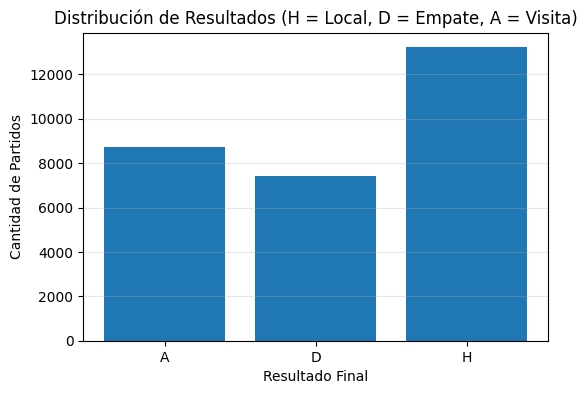

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

print("--- Distribución del Resultado Final (H, D, A) ---")

# 1. Contamos cuántos partidos fueron H, D, A
df_resultados = (
    df_entrenamiento_final
        .groupBy("resultado_final")
        .count()
        .orderBy("resultado_final")
)

# 2. Convertimos a Pandas para graficar
pdf = df_resultados.toPandas()

# 3. Gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(pdf["resultado_final"], pdf["count"])
plt.title("Distribución de Resultados (H = Local, D = Empate, A = Visita)")
plt.xlabel("Resultado Final")
plt.ylabel("Cantidad de Partidos")
plt.grid(axis="y", alpha=0.3)
plt.show()


## Histograma goles con línea 2.5


--- Histograma de Goles Totales (Over/Under 2.5) ---


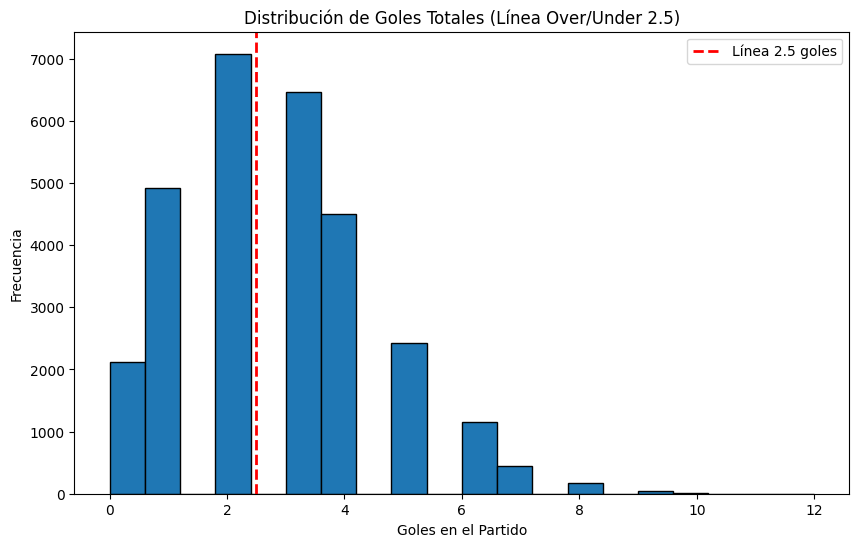

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col

print("\n--- Histograma de Goles Totales (Over/Under 2.5) ---")

df_goles = df_entrenamiento_final.withColumn(
    "goles_totales",
    col("goles_local") + col("goles_visitante")
)

pdf_goles = df_goles.select("goles_totales").toPandas()

plt.figure(figsize=(10,6))
plt.hist(pdf_goles["goles_totales"], bins=20, edgecolor="black")

plt.axvline(2.5, color="red", linestyle="--", linewidth=2, label="Línea 2.5 goles")

plt.title("Distribución de Goles Totales (Línea Over/Under 2.5)")
plt.xlabel("Goles en el Partido")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()


## Boxplot cuota_local vs resultado_final


--- Cuota Local vs Resultado Final ---


<Figure size 800x500 with 0 Axes>

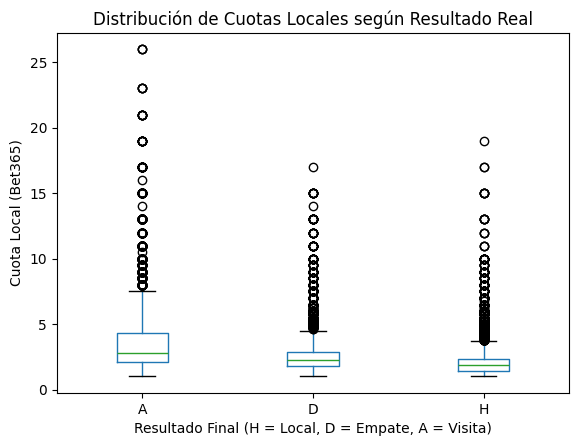

In [12]:
import matplotlib.pyplot as plt

print("\n--- Cuota Local vs Resultado Final ---")

df_box = df_final.select("cuota_local", "resultado_final").toPandas()

plt.figure(figsize=(8, 5))
df_box.boxplot(by="resultado_final", column=["cuota_local"], grid=False)

plt.title("Distribución de Cuotas Locales según Resultado Real")
plt.suptitle("")
plt.xlabel("Resultado Final (H = Local, D = Empate, A = Visita)")
plt.ylabel("Cuota Local (Bet365)")
plt.show()


# Preparación de Datos para el Modelado 

## Indexacion

* Convertimos el texto 'resultado_final' (H, D, A) en números (0.0, 1.0, 2.0)
* StringIndexer detecta las categorías y les asigna un índice.
* Sumamos los goles para predecir el Over/Under


In [13]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

print("---INDEXACIÓN DE TARGETS ---")

# Target para CLASIFICACIÓN (1X2)
indexer = StringIndexer(inputCol="resultado_final", outputCol="label_resultado")
model_indexer = indexer.fit(df_entrenamiento_final)
df_indexed = model_indexer.transform(df_entrenamiento_final)

#Target para REGRESIÓN (Goles Totales)
df_indexed = df_indexed.withColumn("total_goles", col("goles_local") + col("goles_visitante"))

print("Targets creados:")
print("   - 'label_resultado' (para Random Forest)")
print("   - 'total_goles' (para Regresión Lineal)")

df_indexed.select("fecha", "resultado_final", "label_resultado", "total_goles").show(5)

--- PASO 1: INDEXACIÓN DE TARGETS ---


Targets creados:
   - 'label_resultado' (para Random Forest)
   - 'total_goles' (para Regresión Lineal)


+----------+---------------+---------------+-----------+
|     fecha|resultado_final|label_resultado|total_goles|
+----------+---------------+---------------+-----------+
|2011-08-20|              D|            2.0|          2|
|2011-09-10|              H|            0.0|          4|
|2011-09-21|              A|            1.0|          4|
|2011-10-16|              A|            1.0|          4|
|2011-10-29|              A|            1.0|          2|
+----------+---------------+---------------+-----------+
only showing top 5 rows



## Vectorización

* Definimos qué columnas usará el modelo para aprender (X)
* SOLO usamos información conocida ANTES del partido (Rachas + Cuotas)

In [14]:
from pyspark.ml.feature import VectorAssembler

print("--- VECTORIZACIÓN DE FEATURES ---")


input_cols = [
    # Inteligencia Deportiva (Rachas)
    "local_racha_puntos",
    "local_racha_goles_favor",
    "local_racha_goles_contra",
    "visita_racha_puntos",
    "visita_racha_goles_favor",
    "visita_racha_goles_contra",

    # Información de Mercado (Cuotas)
    "cuota_local",
    "cuota_empate",
    "cuota_visitante"
]

# Creamos el ensamblador
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

# Transformamos el DataFrame
df_ml_ready = assembler.transform(df_indexed)

print("Vectorización completada. Columna 'features' creada.")
df_ml_ready.select("fecha", "features", "label_resultado").show(5, truncate=False)

--- VECTORIZACIÓN DE FEATURES ---
Vectorización completada. Columna 'features' creada.


+----------+--------------------------------------+---------------+
|fecha     |features                              |label_resultado|
+----------+--------------------------------------+---------------+
|2011-08-20|[0.5,0.5,1.5,2.0,1.5,1.0,2.38,3.1,3.1]|2.0            |
|2011-09-10|[0.5,0.75,2.0,0.8,0.8,1.2,2.5,3.0,3.0]|0.0            |
|2011-09-21|[1.0,1.2,2.0,2.0,1.8,0.8,3.5,3.1,2.2] |1.0            |
|2011-10-16|[1.0,1.2,1.8,2.6,2.0,0.6,6.0,3.6,1.62]|1.0            |
|2011-10-29|[0.4,0.8,2.0,0.6,1.0,2.0,3.6,3.1,2.15]|1.0            |
+----------+--------------------------------------+---------------+
only showing top 5 rows



# Guardar en formato parquet

In [16]:
df_ml_ready.write.mode("overwrite").parquet("hdfs:///user/johan/data/processed/")

25/11/23 05:38:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

In [17]:
spark.stop()